In [1]:
!pip install pandas
!pip install numpy

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
print(tf.__version__)
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_roc_curve, auc, roc_curve, roc_auc_score
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
import random
import os

2.4.1


In [3]:
# !pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback

In [4]:
print("Num GPUs Available: ", tf.config.list_physical_devices('GPU'))

Num GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [31]:
class CustomLearningRateScheduler(keras.callbacks.Callback):
    def __init__(self, schedule):
        super(CustomLearningRateScheduler, self).__init__()
        self.schedule = schedule

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, "lr"):
            raise ValueError('Optimizer must have a "lr" attribute.')
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        scheduled_lr = self.schedule(epoch, lr)
        tf.keras.backend.set_value(self.model.optimizer.lr, scheduled_lr)
        print("\nEpoch %05d: Learning rate is %.12f." % (epoch, scheduled_lr))

LR_SCHEDULE = [
    (5, 0.000001),
    (10, 0.0000001),
    (15, 0.00000001),
    (20, 0.000000001),
    (25, 0.0000000001),
    (30, 0.00000000001)
]


def lr_schedule(epoch, lr):
    if epoch < LR_SCHEDULE[0][0] or epoch > LR_SCHEDULE[-1][0]:
        return lr
    for i in range(len(LR_SCHEDULE)):
        if epoch == LR_SCHEDULE[i][0]:
            return LR_SCHEDULE[i][1]
    return lr

def lr_schedule_1(epoch, lr):
    decay_rate = 0.1
    decay_step = 4
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

In [6]:
import os
os.getcwd()

'/home/vad/Projects/all_cups_missing_plane'

In [7]:
data_train = pd.read_csv(r'/home/vad/Projects/all_cups_missing_plane/data/train.csv', dtype=str)
data_test = pd.read_csv(r'/home/vad/Projects/all_cups_missing_plane/data/test.csv', dtype=str)
data_train.head(3)

,sign,filename
0,0,200d8766-4240-44d1-a2da-65dc4ee7973a
1,0,87174854-b7b6-4cb2-8183-4ca2bbd26b9d
2,0,c089638e-b683-436a-a3a3-3e5be972c4f6


In [8]:
def append_png(fn):
    return fn+".png"
data_train["png"]=data_train["filename"].apply(append_png)
data_test["png"]=data_test["filename"].apply(append_png)

In [9]:
samples = np.random.rand(len(data_train)) < 0.8
df_train = data_train[samples]
df_test = data_train[~samples]

In [10]:
base_dir = r'/home/vad/Projects/all_cups_missing_plane/data'
train_dir = r'/home/vad/Projects/all_cups_missing_plane/data/avia-train'
test_dir = r'/home/vad/Projects/all_cups_missing_plane/data/avia-test'
cpt_path = r'/home/vad/Projects/all_cups_missing_plane/data/models/'

In [11]:
BATCH_SIZE = 128
IMAGE_SIZE = 20
train_gen = ImageDataGenerator(
    rotation_range=45,
    rescale=1./255, 
    horizontal_flip=True
)
test_gen = ImageDataGenerator(rescale = 1./255)

In [12]:
train_data = train_gen.flow_from_dataframe(dataframe=df_train, 
                                           directory=train_dir, x_col='png', 
                                           y_col='sign', seed=42, 
                                           batch_size=BATCH_SIZE,
                                           shuffle=False,  
                                           class_mode='binary',
                                           validate_filenames=False,
                                           target_size=(IMAGE_SIZE, IMAGE_SIZE))

val_data = train_gen.flow_from_dataframe(dataframe=df_test, 
                                           directory=train_dir, x_col='png', 
                                           y_col='sign', 
                                           batch_size=BATCH_SIZE,
                                           shuffle=False,  
                                           class_mode='binary',
                                           validate_filenames=False,
                                           target_size=(IMAGE_SIZE, IMAGE_SIZE))

test_data = test_gen.flow_from_dataframe(dataframe=data_test, 
                                         directory=test_dir, x_col='png', 
                                         y_col=None,
                                         batch_size=BATCH_SIZE, 
                                         shuffle=False, 
                                         class_mode=None,
                                         validate_filenames=False,
                                         target_size=(IMAGE_SIZE, IMAGE_SIZE))

full_data = train_gen.flow_from_dataframe(dataframe=data_train, 
                                           directory=train_dir, x_col='png', 
                                           y_col='sign', seed=42, 
                                           batch_size=BATCH_SIZE,
                                           shuffle=True,  
                                           class_mode='binary',
                                           validate_filenames=False,
                                           target_size=(IMAGE_SIZE, IMAGE_SIZE))

Found 24765 non-validated image filenames belonging to 2 classes.
Found 6315 non-validated image filenames belonging to 2 classes.
Found 1000 non-validated image filenames.
Found 31080 non-validated image filenames belonging to 2 classes.


In [50]:
def make_model(dropout=0.0):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), 
                                  activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
#     model.add(tf.keras.layers.Dropout(dropout))
    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), 
                                  activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
#     model.add(tf.keras.layers.Dropout(dropout))
    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), 
                                  activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), 
                                  activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), 
                                  activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), 
                                  activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), 
                                  activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), 
                                  activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(dropout))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), 
                                  activation='relu', padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), 
                                  activation='relu', padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
#     model.add(tf.keras.layers.Dropout(dropout))
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), 
                                  activation='relu', padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
#     model.add(tf.keras.layers.Dropout(dropout))
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), 
                                  activation='relu', padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
#     model.add(tf.keras.layers.Dropout(dropout))
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), 
                                  activation='relu', padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
#     model.add(tf.keras.layers.Dropout(dropout))
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), 
                                  activation='relu', padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), 
                                  activation='relu', padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), 
                                  activation='relu', padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(dropout))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
    
    model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), 
                                  activation='relu', padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
#     model.add(tf.keras.layers.Dropout(dropout))
    model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), 
                                  activation='relu', padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
#     model.add(tf.keras.layers.Dropout(dropout))
    model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), 
                                  activation='relu', padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
#     model.add(tf.keras.layers.Dropout(dropout))
    model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), 
                                  activation='relu', padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), 
                                  activation='relu', padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), 
                                  activation='relu', padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), 
                                  activation='relu', padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), 
                                  activation='relu', padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(dropout))
    
#     model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), 
#                                   activation='relu', padding='same'))
#     model.add(tf.keras.layers.BatchNormalization())
#     model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), 
#                                   activation='relu', padding='same'))
#     model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), 
                                  activation='relu', padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(dropout))
    model.add(tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), 
                                  activation='relu', padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(dropout))
    
    
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(256))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(dropout))
    model.add(tf.keras.layers.Dense(128))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(dropout))
    model.add(tf.keras.layers.Dense(64))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(dropout))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                loss=tf.keras.losses.binary_crossentropy,
                metrics=[tf.keras.metrics.AUC()])
    return model

model = make_model(dropout=0.4)

In [51]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_286 (Conv2D)          (None, 20, 20, 32)        896       
_________________________________________________________________
batch_normalization_329 (Bat (None, 20, 20, 32)        128       
_________________________________________________________________
conv2d_287 (Conv2D)          (None, 20, 20, 32)        9248      
_________________________________________________________________
batch_normalization_330 (Bat (None, 20, 20, 32)        128       
_________________________________________________________________
conv2d_288 (Conv2D)          (None, 20, 20, 32)        9248      
_________________________________________________________________
batch_normalization_331 (Bat (None, 20, 20, 32)        128       
_________________________________________________________________
conv2d_289 (Conv2D)          (None, 20, 20, 32)      

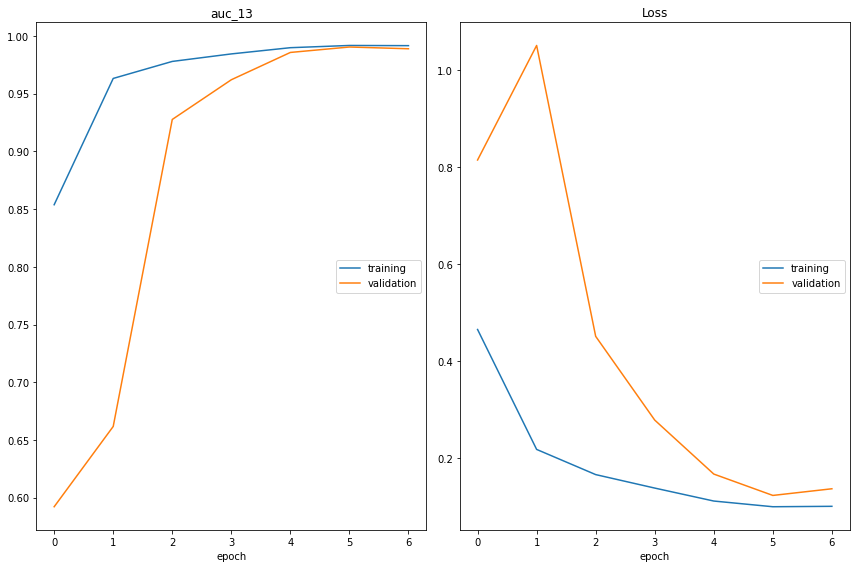

auc_13
	training         	 (min:    0.854, max:    0.992, cur:    0.992)
	validation       	 (min:    0.592, max:    0.990, cur:    0.989)
Loss
	training         	 (min:    0.099, max:    0.465, cur:    0.100)
	validation       	 (min:    0.122, max:    1.051, cur:    0.136)
Epoch 8/50

Epoch 00007: Learning rate is 0.000100000005.
194/194 [==============================] - ETA: 0s - loss: 0.0947 - auc_13: 0.9923

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='val_loss', verbose=1, save_best_only=True)
EPOCHS = 50
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    callbacks=[checkpoint, PlotLossesCallback(), CustomLearningRateScheduler(lr_schedule_1)])

In [ ]:
val_data_pred = model.predict(val_data)
fpr, tpr, thresholds = roc_curve(df_test['sign'].astype(int), val_data_pred)

In [ ]:
def plot_roc_curve(fpr,tpr): 
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.show()
    # Zoom in view of the upper left corner.
    plt.figure(2)
    plt.xlim(0, 0.3)
    plt.ylim(0.9, 1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve (zoomed in at top left)')
    plt.show()

plot_roc_curve(fpr,tpr) 

In [ ]:
auc_score=roc_auc_score(df_test['sign'].astype(int), val_data_pred)
print(auc_score)
print("")

In [ ]:
def submit(data_test, predict, auc=0.9):
    test = pd.DataFrame(predict, columns=['Predict'])
    result = pd.concat([data_test, test], axis=1)
    result['sign']  = result['Predict'].apply(lambda x: 1 if x > auc else 0)
    result.drop(['png', 'Predict'], axis=1, inplace=True)
    result.to_csv('Subbmision.csv', columns=['sign', 'filename'], index=False)

In [ ]:
def full_model_learn(EPOCHS):
    model_full = make_model(dropout=0.4)
    model_full.fit(full_data, epochs=EPOCHS, callbacks=[checkpoint, PlotLossesCallback(), CustomLearningRateScheduler(lr_schedule_1)])
    predict = model_full.predict(test_data)
    return predict, model_best

In [ ]:
full_pred, best_model = full_model_learn(50)

In [ ]:
submit(data_test, model.predict(test_data), auc=0.67)

In [ ]:
testing = model.predict(test_data)
testing = pd.DataFrame(testing, columns=['Predict'])

In [ ]:
testing['Predict'].sum()

In [ ]:
for i in np.arange(0, 1, 0.001):
    testing['sign' + str(i)]  = testing['Predict'].apply(lambda x: 1 if x > i else 0)
    print(i, sum(testing['sign' + str(i)]))

In [ ]:
testing.sum(axis=1)

In [ ]:
testing = model.predict(val_data)

In [ ]:
testing = pd.DataFrame(testing, columns=['Predict'])
testing